# BEAT-PD Challenge

Challenge website : https://www.synapse.org/#!Synapse:syn20825169/wiki/596118

Data information : https://www.synapse.org/#!Synapse:syn20825169/wiki/600405


### Ideas/Doubts [Laureano]

VAD like thing to remove unwanted data?
modified MFCC?
X,Y,Z = relative positions or acceleration?

Imp: Predict per person. Maybe UBM like thing and adapt it

In [227]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

from sklearn.model_selection import StratifiedKFold

In [122]:
# Data paths

data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
# FIXME : Move this to data?
path_save_accelerometer_plots = ("/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/")

In [204]:
def define_data_type(data_type, training_or_ancillary='training_data', data_real_subtype=None):
    """
    Setup file names
    
    Keyword arguments:
    - data_type = {cis , real}
    - training_or_ancillary: {'training_data', 'ancillary_data'} to switch between both
    - data_real_subtype: only provided for REAL-PD 

    If data_type is real, data_real_subtype will have to be declared as well 
    data_real_subtype={smartphone_accelerometer, smartwatch_accelerometer, smartwatch_gyroscope}
    """
    if data_type == "cis":
        # CIS-PD_Training_Data_IDs_Labels.csv
        # CIS-PD_Ancillary_Data_IDs_Labels.csv
        path_train_labels = (
            data_dir
            + data_type
            + "-pd.data_labels/"
            + data_type.upper()
            + "-PD_"
            + ("Training_Data" if training_or_ancillary == 'training_data' else "Ancillary_Data")
            +"_IDs_Labels.csv"
        )
        path_train_data = data_dir + data_type + "-pd."+training_or_ancillary+"/"

    if data_type == "real":
        path_train_labels = (
            data_dir
            + data_type
            + "-pd.data_labels/"
            + data_type.upper()
            + "-PD_"
            + ("Training_Data" if training_or_ancillary == 'training_data' else "Ancillary_Data")
            +"_IDs_Labels.csv"
        )
        print('path_train_labels : ', path_train_labels)
        path_train_data = (
            data_dir + data_type + "-pd."+training_or_ancillary+"/" + data_real_subtype + "/"
        )

    # Display labels
    df_train_label = pd.read_csv(path_train_labels)
    return path_train_data, df_train_label

In [124]:
def get_plot_title(idx, df_train_label):
    """
    Create a title that identifies the plotted graph with the measurement_id, 
    subject_id, on_off label, dyskinesia and tremor labels.
    
    Keyword arguments:
    - idx: 
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    
    Returns: A string concatenating all the values mentioned 
    """
    # Following val_* variables are only used to format a cute title for the charts
    val_subject_id = df_train_label.loc[[idx]]["subject_id"].values[0]
    val_on_off = df_train_label.loc[[idx]]["on_off"].values[0]
    val_dyskinesia = df_train_label.loc[[idx]]["dyskinesia"].values[0]
    val_tremor = df_train_label.loc[[idx]]["tremor"].values[0]
    return "{0} = on_off: {1}, dyskinesia: {2}, tremor: {3}".format(
        val_subject_id, val_on_off, val_dyskinesia, val_tremor
    )

In [125]:
def plot_accelerometer(data_type, path_accelerometer_plots, path_inactivity=None):
    """
    Plots the accelerometer data. There will be 3 subplots for each axis (X, Y, Z)
    
    Keyword arguments: 
    - data_type={cis , real} : It depends on which database is used 
    - path_accelerometer_plots: Path where the accelerometer plots are going to be saved 
    - path_inactivity: Path where the dataframe with inactivity  removed are 
    """
    # Iterating through all the indexes contained in df_train_label
    for idx in df_train_label.index:
        if path_inactivity is None:
            df_train_data = pd.read_csv(
                path_train_data + df_train_label["measurement_id"][idx] + ".csv"
            )
        else:
            df_train_data = pd.read_csv(
                path_inactivity + df_train_label["measurement_id"][idx] + ".csv"
            )

        # FIXME: BUG ?  why the following goes to 1000xxx sometimes? It should be max 59xxx
        print("measurement_id : ", df_train_label["measurement_id"][idx])
        # Following val_* variables are only used to format a cute title for the charts
        great_title = get_plot_title(idx, df_train_label)

        # The time doesn't have the same name depending on the data_type
        x_axis_data_type = "t" if data_type == "real" else "Timestamp"

        # Normalize the data
        cols_to_norm = ["x", "y", "z"] if data_type == "real" else ["X", "Y", "Z"]
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(
            lambda x: (x - x.min()) / (x.max() - x.min())
        )

        df_train_data.plot(
            x=x_axis_data_type, legend=True, subplots=True, title=great_title
        )

        # Save plotted graph with the measurement_id as name of the file
        plt.savefig(
            path_accelerometer_plots + df_train_label["measurement_id"][idx] + ".png"
        )
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()

In [126]:
def prepro_missing_values(df_train_label):
    """
    Filling NaN values with -1. 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    # Replace NaN values with -1.0 because otherwise plotting triggers an error
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label


def compute_symptoms_occurences_dataframe(df_train_label):
    """
    Computes how many times the symptoms are occuring for a single subject_id 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    df_train_label = prepro_missing_values(df_train_label=df_train_label)

    # Group data by subject_id
    df_train_label_subject_id = df_train_label.groupby("subject_id")

    df_occurences = []
    symptoms = ["on_off", "dyskinesia", "tremor"]

    for key, value in df_train_label_subject_id:
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = (
                df_train_label_subject_id.get_group(key)
                .iloc[:, -3:][symptom]
                .value_counts()
            )

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(
                    (
                        {
                            "subject_id": key,
                            "symptom": symptom,
                            "symptom_value": symptom_value,
                            "occurence": symptom_occurence,
                        }
                    )
                )

    df_occurences = pd.DataFrame(
        df_occurences, columns=("subject_id", "symptom", "symptom_value", "occurence")
    )

    return df_occurences, df_train_label_subject_id

In [143]:
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    """
    This function plots the occurences of symptoms according to subject_id 

    Keyword Arguments: 
    - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
    - df_train_label_subject_id: contains df_train_label grouped by subject_id 
    """
    print('#11111111')
    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = (
        df_occurences.subject_id.nunique()
    )  # nb of unique patients in the label file
    print("Nb subject_id h: ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 10
    fig, axes = plt.subplots(
        nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
    )  # 3 cols for the 3 symptoms
    print('#2')
    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
    # it is incremented
    patient = -1

    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ["on_off", "dyskinesia", "tremor"]
    for key, value in df_train_label_subject_id:
        print('#3')
        patient = patient + 1  # value used to position the plots (row)
        symptom_no = 0  # value only used to position the plots (col)
        for symptom in symptoms:
            print('#4')
            subject_symptom = " ".join(
                [str(key), symptom]
            )  # variable used to create a title for each plot
            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
                kind="bar",
                x=symptom,
                title=subject_symptom,
                ax=axes[patient, symptom_no],
                sharey=True,
            )
            print('#6')
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1

In [214]:
def interesting_patients(df_train_label, list_measurement_id):
    """
    Filters df_train_label according to a list of measurement_id we are interested in analyzing

    Keyword Arguments:
    - df_train_label: Labels DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    - list_measurement_id: list of measurement_id 

    Returns:
    - df_train_label: filtered df_train_label containing only the measurements_id we are interested in 
    """

    filter_measurement_id = df_train_label.measurement_id.isin(list_measurement_id)

    df_train_label = df_train_label[filter_measurement_id]

    return df_train_label

possible to have participant characteristics from additional db data? ex https://ieeexplore.ieee.org/abstract/document/7911257

## WIP : Function to remove silence (inactivity)

In [76]:
def get_df_threshold(threshold_energy, max_values):
    """
    This function returns a dataframe of shape (3,1) containing what is the treshold for each X,Y,Z axis 
    depending on threshold_energy. 

    For example if threshold_energy=10, the function is going to return what is 10% of the max_values

    Arguments:
    - threshold_energy: Percentage of the max values we want to use as treshold 
    - max_values: Dataframe of the max values 
    """
    return (max_values * threshold_energy) / 100

### Mean offset removal

In [11]:
def remove_inactivity_mean_offset(df_train_label):
    """
    Removal of inactivity segments detected with a threshold after the energy is centered over the mean
    This function is expected to be less efficient than removal of inactivity with the highpass threshold 
    
    Keyword arguments: 
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    for idx in df_train_label.index:
        df_train_data = pd.read_csv(
            path_train_data + df_train_label["measurement_id"][idx] + ".csv"
        )

        ### Following section works on removing offset with mean
        inputData_DCRemoved = df_train_data.iloc[:, -3:] - df_train_data.iloc[
            :, -3:
        ].mean(axis=0)

        # inputData with DC Removed only has NaN for the Timestamp values, so we are adding them
        inputData_DCRemoved.insert(0, "Timestamp", df_train_data["Timestamp"])

        # Plot the graph
        great_title = get_plot_title(idx, df_train_label)
        print(df_train_label["measurement_id"][idx])
        inputData_DCRemoved.plot(
            x="Timestamp", legend=True, subplots=True, title=great_title
        )

        ### Following section works on removing inactivity following a treshold
        # Get the absolute max values for X, Y, Z
        max_values = inputData_DCRemoved.iloc[:, -3:].abs().max()

        # Compute what is X% of that max
        df_treshold = get_df_threshold(10, max_values)

        df_candidates = inputData_DCRemoved[
            (inputData_DCRemoved.X.abs() <= df_treshold["X"])
            & (inputData_DCRemoved.Y.abs() <= df_treshold["Y"])
            & (inputData_DCRemoved.Z.abs() <= df_treshold["Z"])
        ]

        print("Candidates to be removed:")
        display(df_candidates)

        filter_df = inputData_DCRemoved[
            ~inputData_DCRemoved.isin(df_candidates)
        ].dropna(how="all")
        great_title = "filter_df for : " + great_title
        filter_df.plot(x="Timestamp", legend=True, subplots=True, title=great_title)

        # FIXME: This function is not done. As it's not the priority, i'm switching to work on highpass filter
        # It doesn't remove the identified candidates or save the 0/1 vector

### High pass filter 

In [77]:
# Source of the code about the highpass: https://gist.github.com/junzis/e06eca03747fc194e322
# A bit more explanation here: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def remove_inactivity_highpass(
    df_train_label,
    energy_threshold,
    duration_threshold,
    mask_path,
    plot_frequency_response=False,
    plot_accelerometer_after_removal=False,
):
    """
    Removes inactivity according to a high pass filter. It will only be applied to the measurement_id provided
    in the df_train_label variable. A first condition for a measurement to be removed at a certain timestamp
    is that first, the energy is less than the energy_treshold. After that, we identify candidates with a vector
    where 0 represents a timestamp we want to keep, and 1 represents timestamps we detected as below the minimum 
    energy threshold. 
    
    The second threshold, called duration_threshold, represents the condition that there must be a minimum 
    number of consecutives candidates to be removed befoer the candidates will be indeed removed and confirmed
    as inactivity. For example, we could decide to only remove sections that are at least 1 minute long of 
    inactivity detected.
    
    Keyword Arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    - energy_threshold: what percentage of the max energy do we consider as inactivity?
        For example, 1 of the max is considered as inactivity
    - duration_threshold: how long do we want to have inactivity before we remove it? 
        For example 3000x0.02ms=1min of inactivity minimum before those candidates are removed
    - mask_path: Path where to save the mask 
    - plot_frequency_response: Optional. {True, False}. 
                               Flag to determine if we want to plot the frequency response or not
    -plot_accelerometer_after_removal: Optinal. {True, False}.
                                Flag to determine if we want to plot the accelerometer after the inactivity
                                is removed
    """
    # Filter requirements.
    order = 10
    fs = 50.0  # sample rate, Hz
    cutoff = 0.5  # 3.667  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)

    # Load every training file for each "row of labels" we have loaded in df_train_label
    for idx in df_train_label.index:
        # Load the training data
        try:
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
            print('Working on ', df_train_label["measurement_id"][idx])
        except FileNotFoundError:
            print(path_train_data)
            print('Skipping ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)
            continue
        # Set the time axis. It's not the same name for the two databases
        x_axis_data_type = "t" if data_type == "real" else "Timestamp"
        t = df_train_data[x_axis_data_type]

        # Filter the data
        # X = [:,-3], Y = [:,-2], Z = [:,-1]
        X_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-3], cutoff, fs, order)
        Y_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-2], cutoff, fs, order)
        Z_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-1], cutoff, fs, order)

        ### Following section works on removing inactivity following a treshold
        # Get the absolute max values for X, Y, Z
        # FIXME: This could be made better but I won't lose time on this now
        # Get in a Series format because that's what the threshold function is expecting
        max_values = pd.Series(np.array([
                    np.abs(X_filtered_data).max(),
                    np.abs(Y_filtered_data).max(),
                    np.abs(Z_filtered_data).max(),
                ]))

        # Get the threshold of the filtered data
        df_treshold = get_df_threshold(energy_threshold, max_values)
#         print('df threshold : ', df_treshold)
        # Get 0/1 candidates
        X_zeros = np.abs(X_filtered_data) <= df_treshold[0]
        Y_zeros = np.abs(Y_filtered_data) <= df_treshold[1]
        Z_zeros = np.abs(Z_filtered_data) <= df_treshold[2]
        
#         display(X_zeros)
#         display(Y_zeros)
#         display(Z_zeros)
        
        # Change data from boolean to 0 and 1s (int)
        X_zeros = X_zeros.astype(int)
        Y_zeros = Y_zeros.astype(int)
        Z_zeros = Z_zeros.astype(int)
        # AND operand to identify candidates across all axis
        # FIXME: change name of variable bc it's not a df
        df_zeros = X_zeros & Y_zeros & Z_zeros


        # Check if it reaches the time treshold (like minimum 1 minute long to be removed)
        start = 0  # Start and end of the series of 1
        end = 0
        indices_list = []  # List of tuples
        howmany = 0  # How many groups we identified (not required, just nice metric)
        count = 0  # How many 1 in a row we found

        # Counts the number of 0s and 1s in the original data before we apply the threshold
#         unique, counts = np.unique(df_zeros, return_counts=True)
#         print(dict(zip(unique, counts)))

        # Change the candidates for removal (1) to 0 if there are not enough 1s in a row to reach the
        # threshold. For example there needs to be 3000 times 1s in a row for 1 minute of "inactivity"
        # to be removed
        for i in range(0, len(df_zeros)):
            if df_zeros[i] == 1:
                count = count + 1
            else:
                if count >= duration_threshold:
                    start = i - count
                    end = i - 1
                    indices_list.append((start, end))
                    howmany = howmany + 1
                    count = 0
                elif (
                    count >= 1
                ):  # if it doesn't reach the threshold, we change the 1 for 0 because we don't want to remove those
                    start = i - count
                    end = i
                    df_zeros[start:end] = [0] * (end - start)
                    count = 0

        #print("There are "+ str(howmany) + " groups identified as candidates to be removed")

        # Counts the number of 0s and 1s in the data after we applied the threshold
#         unique, counts = np.unique(df_zeros, return_counts=True)
#         print(dict(zip(unique, counts)))

        # Save 0/1 candidates to csv
        # I use 1-df_zeros to swap the 0s and 1s.
        # 1: we want to keep this measure
        # 0: detected as inactivity so we want to remove it
        # Previously, it was the opposite, as 1s were considered inactivity
        df_mask_highpass = pd.DataFrame(1 - df_zeros)
        df_mask_highpass.to_csv(
            mask_path + df_train_label["measurement_id"][idx] + ".csv",
            index=False,
            header=False,
        )
        
        

        # Plot the accelerometer with the removed sections
        # The [0] is used to get a pandas.Series instead of a DataFrame
        # We insert Timestamp again as it was removed for the filtering
        # BUG : Should I use df_train_data or the filtered high pass dataframe?
        if plot_accelerometer_after_removal:
            filtered_df = df_train_data.iloc[:, -3:].multiply(df_mask_highpass[0], axis=0)
            print('LEN FILTERED DF : ', len(filtered_df))
            filtered_df.insert(0, x_axis_data_type, df_train_data[x_axis_data_type])
            great_title = get_plot_title(idx, df_train_label)
            filtered_df.plot(
                x=x_axis_data_type, legend=True, subplots=True, title=great_title
            )
            display(filtered_df)
            plt.show()
            plt.clf()
            plt.cla()
            plt.close()

        # Plot the frequency response, and plot both the original and filtered signals for X, Y and Z.
        if plot_frequency_response:
            # TODO: Make the graphs bigger
            w, h = freqz(b, a, worN=8000)
            plt.subplot(4, 1, 1)
            plt.plot(0.5 * fs * w / np.pi, np.abs(h), "b")
            plt.plot(cutoff, 0.5 * np.sqrt(2), "ko")
            plt.axvline(cutoff, color="k")
            plt.xlim(0, 0.5 * fs)
            plt.title("Highpass Filter Frequency Response")
            plt.xlabel("Frequency [Hz]")
            plt.grid()

            # Plot X
            plt.subplot(4, 1, 2)
            plt.plot(t, df_train_data.iloc[:,-3], "b-", label="X")
            plt.plot(t, X_filtered_data, "g-", linewidth=2, label="filtered X")
            plt.legend()
            plt.grid()

            # Plot Y
            plt.subplot(4, 1, 3)
            plt.plot(t, df_train_data.iloc[:,-2], "b-", label="Y")
            plt.plot(t, Y_filtered_data, "g-", linewidth=2, label="filtered Y")
            plt.legend()
            plt.grid()

            plt.subplot(4, 1, 4)
            plt.plot(t, df_train_data.iloc[:,-1], "b-", label="Z")
            plt.plot(t, Z_filtered_data, "g-", linewidth=2, label="filtered Z")
            plt.legend()

            plt.xlabel("Time [sec]")
            plt.grid()

            plt.subplots_adjust(hspace=0.7)
            plt.show()

            plt.show()
            plt.clf()
            plt.cla()
            plt.close()

In [250]:
def apply_mask(measurement_id, mask_path):
    """
    Apply a mask on the list of measurement_ids provided through df_train_label 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    # Load the training data
    try:
        df_train_data = pd.read_csv(path_train_data + measurement_id + ".csv")
        # smartwatch_accelerometer and smartwatch_gyroscope have an additional device_id column
        # in the training data and we want to remove it 
        df_train_data = df_train_data.drop(['device_id'], axis=1, errors='ignore')
#         print('PATH : ', mask_path + measurement_id + ".csv")
        df_mask = pd.read_csv(mask_path + measurement_id + ".csv", header=None)
    except FileNotFoundError:
        print('Skipping ' + df_train_label["measurement_id"][idx] +
              ' as it doesn\'t exist for ' +
              data_real_subtype)
        pass


    # multiply df_train_data by mask so the values to be removed are at 0
    #         np.multiply(df2.iloc[:,-3:],df_mask.iloc[:,-1:])
    df_train_data.iloc[:, -3:] = np.multiply(df_train_data.iloc[:, -3:], df_mask)#[:, -1:])

    #         display(df_train_data)

    # Drop the 0 values from the training DataFrame
    df_train_data = df_train_data[(df_train_data.iloc[:, -3:].T != 0).any()]
    df_train_data.reset_index(drop=True, inplace=True)
    return df_train_data

## Get derivative 

In [20]:
def get_derivative_value(df_train_data_context, m):
    """
    TODO 
    
    Keyword arguments:
    - df_train_data_context: TODO
    - m: TODO 
    """
    # Dot Product is the sum of the point wise multiplications between a and m
    cij = np.dot(df_train_data_context, m)
    denum = np.dot(m, m)
    return cij / denum

In [21]:
def get_first_derivative(measurement_id, derivative_path, n_zero=3, padding=False, mask_path=None):
    """
    TODO 
    
    cis-pd.training_data.velocity_original_data: Original data, which means the inactivity is untouched 
    
    Keyword arguments:
    - df_train_label: TODO
    - derivative_path: TODO
    - n_zero: TODO
    - Padding: [False, True] 
      - If True, it will add a padding of [0,0,0] at the beginning and at the end of the training data
      - If False, it will just use the existing values of the training data to have a (7,) vector from the
        training data
    - mask_path: Optinal. If provided, it will apply the high pass mask on the training data 
    """
    # m is a vector. For n_zero, it will be [-3, -2, -1, 0, 1, 2, 3]
    m = np.linspace(-n_zero, n_zero, num=2 * n_zero + 1)

    file_path= data_dir+derivative_path+ measurement_id + '.csv'
    if os.path.isfile(file_path):
        print ("File exist : ", file_path)
        return

    # Load the training data
    if mask_path is not None:
        df_train_data = apply_mask(measurement_id, mask_path)
    else: # Going to get the first derivative from the original data 
        try:
            df_train_data = pd.read_csv(path_train_data + measurement_id + ".csv")
        except FileNotFoundError:
            print('Skipping ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)

    df_velocity = []

    if padding:
        # Padding DataFrame to add 3 empty rows at the beginning and at the end of the training data
        df_padding = []

        # FIXME: This could probably be made faster but I won't lose time on this
        df_padding.insert(0, {"Timestamp": -1, "X": 0, "Y": 0, "Z": 0})
        df_padding.insert(0, {"Timestamp": -1, "X": 0, "Y": 0, "Z": 0})
        df_padding.insert(0, {"Timestamp": -1, "X": 0, "Y": 0, "Z": 0})

        df_train_data = pd.concat(
            [pd.DataFrame(df_padding), df_train_data], ignore_index=True
        )
        df_padding = pd.DataFrame({"Timestamp": [-1, -1, -1],
                                    "X": [0, 0, 0],
                                    "Y": [0, 0, 0],
                                    "Z": [0, 0, 0]})

        df_train_data_padding = df_train_data.append(df_padding, ignore_index=True)
    else:  # FIXME remove this it's just a quickfix because there is the option with or without padding
        # and the next loop has to be on the original dataframe withtout padding
        df_train_data_padding = df_train_data

    # BUG : This df_velocity contains 3 extra rows. I'm not sure where they come from 
    for row in df_train_data[["X", "Y", "Z"]].itertuples():
        end = row.Index + n_zero

        start = row.Index - n_zero

        # QUICKFIX to the padding and pointers issue 
        if start == -3:
            start = 0
            end = 6
        elif start == -2:
            start = 1
            end = 7
        elif start == -1:
            start = 2
            end = 8
        elif end > len(df_train_data) - 1 and not padding:
            end = len(df_train_data)
            start = len(df_train_data) - (2 * n_zero)

        df_velocity.append([get_derivative_value(df_train_data_padding.loc[start:end, "X"], m),
                             get_derivative_value(df_train_data_padding.loc[start:end, "Y"], m),
                             get_derivative_value(df_train_data_padding.loc[start:end, "Z"], m)])

    # Build the DataFrame with all the columns together so we can save it to CSV
    df_velocity = pd.DataFrame(df_velocity, columns=['X','Y','Z'])

    df_velocity.to_csv(
        data_dir + derivative_path + measurement_id + ".csv",
        index=False,
        header=["X_velocity", "Y_velocity", "Z_velocity"],
    )

### Write WAV File for Kaldi

In [257]:
def write_wav(measurement_id, wav_path, mask_path, sAxis):
    """
    Write a wav file 
    
    Keyword arguments:
    - measurement_id: Measurement id of the file we want to write to wav format 
    - wav_path: Path where to save the wav file 
    - mask_path: Path where to apply the mask to the wav file 
    - axis: {'X','Y','Z'}. String. Uppercase. One of the axis
    """
    
    file_path= wav_path + measurement_id + '.wav'
    if os.path.isfile(file_path):
        # FIX ME: it doesn't go here?
        print ("File exist : ", file_path)
    else:
        df_train_data = apply_mask(measurement_id,
                                   mask_path)

        # Save to WAV
        samplerate = 8000 # Hz, we need 8kHz for Kaldi to be happy 

        # We're only writing to WAV file for one of the axis 
        if sAxis == 'X':
            df_train_data_axis = df_train_data.iloc[:,1:2]
        elif sAxis == 'Y':
            df_train_data_axis = df_train_data.iloc[:,2:3]
        elif sAxis == 'Z': 
            df_train_data_axis = df_train_data.iloc[:,3:4]
        write(wav_path +
              measurement_id + '.wav', samplerate, df_train_data_axis.to_numpy())


### How to print accelerometers before/after and write a wav file for 1 file 

In [ ]:
data_type = "cis"
path_train_data, df_train_label = define_data_type(data_type=data_type)

list_measurement_id = ['db2e053a-0fb8-4206-891a-6f079fb14e3a']


df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Plot the accelerometer data
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots)

remove_inactivity_highpass(
    df_train_label,
    energy_threshold=10,
    duration_threshold=3000,
    plot_frequency_response=True,
    plot_accelerometer_after_removal=True,
    mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')


# Apply filter 
for idx in df_train_label.index:
    df_train_data = apply_mask(df_train_label["measurement_id"][idx],
                               mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')
    print('len : ', len(df_train_data))
    great_title = get_plot_title(idx, df_train_label)
    
    print('AFTER REMOVAL')
    #Plot accelerometer 
    print('len : ', len(df_train_data))
    x_axis_data_type = "t" if data_type == "real" else "Timestamp"
    df_train_data.plot(
                    x=x_axis_data_type, legend=True, subplots=True, title=great_title
                )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

# CIS-PD Database

Contains 16 subject_id (patients) for the training set 

- Gender: 11 Male, 5 Female 
- Race: 15 White, 1 NA
- Ethnicity: 15 Not Hispanic or Latino, 1 Unknown
- Age average (standard deviation) : 62.8125 (10.8579)

### CIS-PD: Basic accelerometer visualization

In [ ]:
data_type = "cis"

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)
# display(df_train_label)
# List of interesting measurement id we want to look at
# list_measurement_id=[#'ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
#'db2e053a-0fb8-4206-891a-6f079fb14e3a']#,
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

list_measurement_id = [
    "5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a",
    "cc7b822c-e310-46f0-a8ea-98c95fdb67a1",
    "5163afe8-a6b0-4ea4-b2ba-9b4501dd5912",
    "db2e053a-0fb8-4206-891a-6f079fb14e3a",
    "2d852742-10a9-4c56-9f38-779f2cd66879",
    "2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d",  # no inactivity should be removed
    "3cf49c01-0499-4bad-9167-67691711204a",  # no inactivity should be removed PAS LA??
    "3d0f965c-9d72-43d1-9369-1ea3acf963cc",  # PAS LA ???
    "4b269cc2-8f0c-4816-adbf-10c0069b8833",
    "4bc51b90-bfce-4231-85e1-5de3b4bc0745",
    "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
]  # bit of inactivity in the middle]

list_measurement_id = [
    "2d852742-10a9-4c56-9f38-779f2cd66879",
    "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
    "db2e053a-0fb8-4206-891a-6f079fb14e3a",
]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(
    df_train_label=df_train_label, list_measurement_id=list_measurement_id
)

# Display filtered df_train_label
display(df_train_label)

# path_no_inactivity_data = remove_inactivity_pct_change(df_train_label)

# Plot the accelerometer data
plot_accelerometer(
    data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots
)

### CIS-PD: Create Masks for inactivity removal 

In [63]:
data_type = "cis"
# This is only to switch between training_data or ancillary_data which is additional data provided 
training_or_ancillary_data='ancillary_data' #training_data
path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary_data)

print(path_train_data)

/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.ancillary_data/


In [ ]:
remove_inactivity_highpass(
    df_train_label,
    energy_threshold=5,
    duration_threshold=3000,
    plot_frequency_response=False,
    mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.'+
    training_or_ancillary_data+'.high_pass_mask/')

### CIS-PD: Create first derivative

In [ ]:
do_work = partial(
    get_first_derivative, 
    derivative_path="cis-pd.training_data.velocity_original_data/",
    padding=True, 
    mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/'
)

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = hlist(ex.map(do_work, df_train_label['measurement_id']))

### CIS-PD: Create WAV files - Training Data

#### For Y

In [ ]:
data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type=data_type)

training_or_ancillary='training_data' 

do_work = partial(
    write_wav, 
    wav_path=data_dir+'cis-pd.'+training_or_ancillary+'.wav_test/',
    sAxis='Y'
    mask_path=data_dir+'cis-pd.'+training_or_ancillary+'.high_pass_mask/'
)

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

#### For Z

In [ ]:
data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type=data_type)

training_or_ancillary='training_data' 

do_work = partial(
    write_wav, 
    wav_path=data_dir+'cis-pd.'+training_or_ancillary+'.wav_Z/',
    sAxis='Z'
    mask_path=data_dir+'cis-pd.'+training_or_ancillary+'.high_pass_mask/'
)

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

In [ ]:
data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type=data_type)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]

df_train_label = interesting_patients(
    df_train_label=df_train_label, list_measurement_id=list_measurement_id
)

path_no_inactivity_data = remove_inactivity_pct_change(df_train_label)

# Plot the accelerometer data
# plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots, path_inactivity=path_no_inactivity_data)

#### Distribution of the length of the files

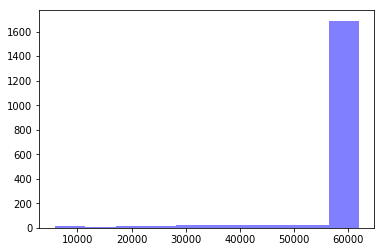

In [80]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type=data_type)

len_distribution = []
for idx in df_train_label.index:
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        len_distribution.append(len(df_train_data))


num_bins = 10
n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
plt.show()


In [85]:
print('min : ', min(len_distribution))
print('max : ', max(len_distribution))

min :  5803
max :  61960


## Visualization: Occurences of each symptoms for each subject

In [ ]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
    df_train_label=df_train_label
)

# Plot the graphs
plot_symptoms_occurences(
    df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
)

## KFold 

In [244]:
def get_k_fold(df_train_label,
               n_splits=5,
               subject_id=None,
               training_or_ancillary='training_data',
               data_real_subtype=""):
    """
    Function that returns a list of X dataframes (X is according to the number of n_splits chosen)

    The dataframes are the labels needed according to the split 

    Keyword Arguments:
    - df_train_label: Dataframe containing the labels
    - n_split: Optional. The number of folds. Default: 5
    - subject_id: Optional. Specify a subject_id to get measurement_id only for that subject_id 
    - data_real_subtype: Only for REAL-PD database
    """
    kf = StratifiedKFold(n_splits) # shuffle??? 

    # Building the dataframe to split
    X = []

    # if we want the data split for one specific subject_id
    if subject_id:
        df_train_label_subject_id = df_train_label.groupby("subject_id")
        X = df_train_label_subject_id.get_group(subject_id)
    else:
        # if we want to have all a split for all data no matter the subject_id
        # NOTE: I didn't make sure to have one subject_id represented in both train/test
        for idx in df_train_label.index:
            X.append([df_train_label["measurement_id"][idx]])
        X = pd.DataFrame(X)

    kf.get_n_splits(X)

    # Building lists of df_train_label because we have by default 5 splits,
    # so the lists will contain 5 DataFrames with different split indices required
    list_df_train_label = list()
    list_df_test_label = list()
    split_idx = 0
    
    # Removing NaN values only for the purpose of kf.split as stratified kfold don't like NaN values
    print(type(X))
    print('Before contains NaN ? : ', X.isnull().sum())
    X_no_nan = prepro_missing_values(X)
    print('After contains NaN ? : ', X_no_nan.isnull().sum())
    
    if subject_id == 1046:
        # 1046 is balanced on tremor because that's the only labels we have for that patient
        y = X_no_nan.iloc[:,-1]
    else:
        # We do the KFOLDs on a balanced on/off only 
        y = X_no_nan.iloc[:,-3] 

    print("----- " + str(subject_id) + " -----")
    for train_index, test_index in kf.split(X_no_nan, y):
        print(len(X))
        print(len(df_train_label))
        df_train_label = X.iloc[train_index]
        df_test_label = X.iloc[test_index]
        
        # Following is just to see if the splits are balanced or not 
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        train_0, train_1, train_2, train_3, train_4 = len(train_y[train_y==0]), \
                                                        len(train_y[train_y==1]), \
                                                        len(train_y[train_y==2]), \
                                                        len(train_y[train_y==3]), \
                                                        len(train_y[train_y==4])
        test_0, test_1, test_2, test_3, test_4  = len(test_y[test_y==0]), \
                                                  len(test_y[test_y==1]), \
                                                  len(test_y[test_y==2]), \
                                                  len(test_y[test_y==3]), \
                                                  len(test_y[test_y==4])
        print('>Train: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d Test: 0=%d, 1=%d, 2=%d, 3=%d, 4=%d' % (train_0, train_1, train_2, train_3, train_4, \
                                                        test_0, test_1, test_2, test_3, test_4))
        
        list_df_train_label.append(df_train_label)
        list_df_test_label.append(df_test_label)

        # name of the file according to its database and type
        # NOTE: Be careful that the end of the name of the folder where to save the kfolds is hardcoded here
        path_save_k_fold_dataframes = (
            data_dir + data_type + "-pd."+training_or_ancillary+".k_fold_v3/" + data_real_subtype + "/"
        )
        df_train_label.to_csv(
            path_save_k_fold_dataframes
            + str(subject_id)
            + "_train_kfold_"
            + str(split_idx)
            + ".csv",
            index=False,
            header=["measurement_id", "subject_id", "on_off", "dyskinesia", "tremor"],
        )
        df_test_label.to_csv(
            path_save_k_fold_dataframes
            + str(subject_id)
            + "_test_kfold_"
            + str(split_idx)
            + ".csv",
            index=False,
            header=["measurement_id", "subject_id", "on_off", "dyskinesia", "tremor"],
        )
        split_idx = split_idx + 1
    return list_df_train_label, list_df_test_label

### Create the K-Fold files for the CIS database 

In [ ]:
# Define the data type as we have two databases
data_type = "cis"
path_train_data, df_train_label = define_data_type(data_type=data_type)

# Group data by subject_id
df_train_label_subject_id = df_train_label.groupby("subject_id")

training_or_ancillary = 'training_data'

# Go through the subject_id and k-fold their data
# FIXME: get_k_fold could me renamed to just create the folds, save them, not return anything
for subject_id, value in df_train_label_subject_id:
    list_df_train_label, list_df_test_label = get_k_fold(
        df_train_label=df_train_label,
        n_splits=5,
        training_or_ancillary=training_or_ancillary,
        subject_id=subject_id
    )


### Read the K-Fold data

In [ ]:
# TODO

### Create the K-Fold Files for the REAL database

In [ ]:
# To generate the files, you have to uncomment one data_real_subtype at a time and
# execute this cell 3 times for the 3 subtypes.

data_type = "real"
training_or_ancillary='training_data' # Either training_data or ancillary_data 

for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)

    # Group data by subject_id
    df_train_label_subject_id = df_train_label.groupby("subject_id")

    # Go through the subject_id and k-fold their data
    for subject_id, value in df_train_label_subject_id:
        list_df_train_label, list_df_test_label = get_k_fold(
            df_train_label=df_train_label,
            n_splits=5,
            subject_id=subject_id,
            training_or_ancillary=training_or_ancillary,
            data_real_subtype=data_real_subtype,
        )

# REAL-PD Database

This database, originally named "Parkinson@Home" is renamed to "Real-PD" for this challenge. The study was made over 2 weeks, with at home monitoring. 

The devices used are an android phone, a motorolla watch. 
- `smartwatch_accelerometer` and `smartwatch_gyroscope` : Motorolla Watch
- `smartphone_accelerometer` : Android phone 

-> Question: so is the smartwatch & smartphone accelerometer should measure the same movements? 

The REAL-PD database has many missing values. 

The subject_id `hbv013` is the only one without missing data. Other patients all have at least one missing symptom (`diskenisia`, ) or two (`on/off and tremor`, `on_off and dyskinesia`, `dyskinesia and tremor`) missing.

Measurements id with no data (`on_off`, `dyskinesia` and `tremor` are all missing):
- `b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8`
- `b598c177-4e38-4ea8-8543-bd8f7e580f96`
- `cf841bf8-0082-4ea3-999f-1f43e39a8dc6`
- `b1e15f8a-109f-459b-ba87-46899240ee66`
- `6f0e2580-56ec-4743-9356-d3e4d9a0aee5`
- `773536f6-9b70-43d0-b099-5d167d74924a`
- `54a0e841-ad45-4ba7-ac83-1785c5f7748b`
- `cd9ed2e2-7e04-44c7-b041-7788f133c193`
- `a6954a91-338b-4523-9e4a-5e69a8fac206`

The 3 symptoms are reported as follows in this dataset: 
- `on_off = {0,1}`
  - `Off` : 0 (medication is wearing off) 
  - `On` : 1 (medication is working)
  
- `dyskinesia = {0,1,2}`
  - Without dyskinesia: 0 
  - Non-troublesome dyskinesia: 1 
  - Severe dyskinesia: 2 
  
- `tremor = {0,1,2,3,4}` 
The description of the database mentions `tremor` is rated from 0 to 4 according to its severity, but from all the data, the maximum value of `tremor` recorded is 3. 

Data:
- ancillary
- clinical : UPDRS evaluation score 
- demographics : #TODO


#### Distribution of the length of the files

smartphone_accelerometer


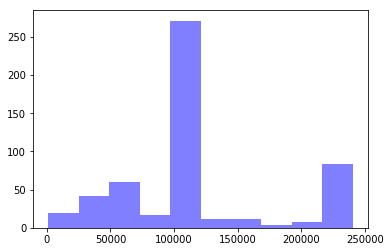

smartwatch_accelerometer


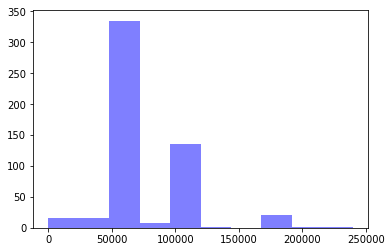

smartwatch_gyroscope


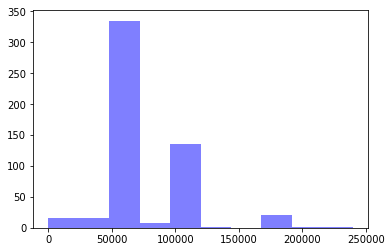

In [174]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "real"
training_or_ancillary='training_data'
data_real_subtype='smartphone_accelerometer'

for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)

    len_distribution = []

    for idx in df_train_label.index:
        try:
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
            len_distribution.append(len(df_train_data))
        except FileNotFoundError:
            continue
    print(data_real_subtype)
    num_bins = 10
    n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
    plt.show()


### REAL-PD: Create Masks for inactivity removal for all subtypes

In [216]:
data_type = "real"
#data_real_subtype='smartphone_accelerometer'
#data_real_subtype = "smartwatch_accelerometer"
#data_real_subtype='smartwatch_gyroscope'

# List of interesting measurement id we want to look at
# list_measurement_id = [
#     "5b4c7c81-659d-40ea-a1fd-59622074fd10",
#     "ee053d95-c155-400d-ae42-fe24834ad4a9",
#     "ce51ee31-8553-4321-9f83-8cd3dabe2f66",
#     "e07708ff-7b8d-4070-af70-3aa81423ab5b",
#     #'7d3f4b7a-167f-4a26-9062-94ce9d8794c1',
#     "99af8d14-cd09-4107-9502-355378ba4e08",
#     #'7d5ac31a-cb53-40f7-8188-0b13724ea55c',
#     "9e43840b-dd89-498b-af1a-a62896a4d5d9",
#     "e391f546-bf8a-46c7-a16c-95bc02f40629",
# ]

# list_measurement_id = ['0c310608-1a32-4b09-b164-375d93ddb2aa']

# Filter df_train_label according to the measurement_id we are most interested in
# df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)
for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    training_or_ancillary='ancillary_data' #training_data
    path_train_data, df_train_label = define_data_type(data_type,
                                                       training_or_ancillary,
                                                       data_real_subtype)

    list_measurement_id= ['f465145e-562d-4c02-b347-bc42ae3b4998']#['33f5a031-43a8-496a-89ee-0b9d99019617', '2515fa8d-8320-4010-bcd9-5dba52b1b5ba']
    # Filter df_train_label according to the measurement_id we are most interested in
    df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

    remove_inactivity_highpass(
        df_train_label,
        energy_threshold=10,
        duration_threshold=3000,
        plot_frequency_response=False,
        plot_accelerometer_after_removal=False,
        mask_path=data_dir+'/real-pd.'+
        training_or_ancillary+
        '.high_pass_mask/'+data_real_subtype+'/')


path_train_labels :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv
Working on  2515fa8d-8320-4010-bcd9-5dba52b1b5ba
/home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.ancillary_data/smartphone_accelerometer/
Skipping 7fde941c-2d8a-4b33-b32d-af016161ee1e as it doesn't exist for smartphone_accelerometer
/home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.ancillary_data/smartphone_accelerometer/
Skipping 92eea111-b6b0-4d07-a624-cf2b0ecea769 as it doesn't exist for smartphone_accelerometer
/home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.ancillary_data/smartphone_accelerometer/
Skipping 3f5adb13-512c-4090-96ac-707703077845 as it doesn't exist for smartphone_accelerometer
Working on  42d34bdc-54a9-4b4f-bed6-c02219c6061f
Working on  3bc6b0d1-0204-4a3d-827a-1579a76b411e
Working on  803d4ad6-328d-494f-8923-329175c8b07f
Working on  f6dde26f-279c-4d83-9e5e-8b25cb7e31bd
Working on  ed9d2a14-cb01-42e6-85f0-180b70b2f821
Working on  83c

SystemError: <built-in method item of numpy.ndarray object at 0x7f427c1b1b20> returned a result with an error set

### REAL-PD: Create first derivative for all subtypes 

In [ ]:
for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type=data_type)
    print(len(df_train_label))
    for idx in df_train_label.index:
        try:
#             print('where we get the file : ', path_train_data)
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        except FileNotFoundError:
            print('Removing ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)
            df_train_label = df_train_label.drop(idx)
        print(len(df_train_label))
    do_work = partial(
        get_first_derivative, 
        derivative_path="real-pd.training_data.derivative_original_data/"+data_real_subtype+'/',
        padding=True, 
        mask_path=data_dir+'/real-pd.training_data.high_pass_mask/'+data_real_subtype+'/'
    )

    num_jobs = 8
    with ProcessPoolExecutor(num_jobs) as ex:
        results = list(ex.map(do_work, df_train_label['measurement_id']))


### REAL-PD: Create WAV files for all subtypes

### X Axis

In [ ]:
data_type = "real"
#FIXME add the one missing when it's done running 
#'smartphone_accelerometer', 'smartwatch_accelerometer', smartwatch_gyroscope
for data_real_subtype in ['smartphone_accelerometer', 'smartwatch_accelerometer', 'smartwatch_gyroscope']:
    training_or_ancillary='ancillary_data' #training_data
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)
#     list_mesurement_id=['33f5a031-43a8-496a-89ee-0b9d99019617']
    # Filter df_train_label according to the measurement_id we are most interested in
#     df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

    for idx in df_train_label.index:
        try:            
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        except FileNotFoundError:
            print('Removing ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)
            df_train_label = df_train_label.drop(idx)
        
    do_work = partial(
        write_wav, 
        wav_path=data_dir+'real-pd.'+training_or_ancillary+'.wav_X/'+data_real_subtype+'/',
        sAxis='X',
        mask_path=data_dir+'/real-pd.'+training_or_ancillary+'.high_pass_mask/'+data_real_subtype+'/'
    )

    num_jobs = 6
    with ProcessPoolExecutor(num_jobs) as ex:
        results = list(ex.map(do_work, df_train_label['measurement_id']))

### Y axis

In [260]:
data_type = "real"

for data_real_subtype in ['smartphone_accelerometer', 'smartwatch_accelerometer', 'smartwatch_gyroscope']:
    training_or_ancillary='training_data' #training_data
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)

    for idx in df_train_label.index:
        try:            
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        except FileNotFoundError:
            print('Removing ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)
            df_train_label = df_train_label.drop(idx)
        
    do_work = partial(
        write_wav, 
        wav_path=data_dir+'real-pd.'+training_or_ancillary+'.wav_Y/'+data_real_subtype+'/',
        sAxis='Y',
        mask_path=data_dir+'/real-pd.'+training_or_ancillary+'.high_pass_mask/'+data_real_subtype+'/'
    )

    num_jobs = 8
    with ProcessPoolExecutor(num_jobs) as ex:
        results = list(ex.map(do_work, df_train_label['measurement_id']))

path_train_labels :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/real-pd.data_labels/REAL-PD_Training_Data_IDs_Labels.csv
Removing d3c89012-3ab9-4014-b577-61ff05e31968 as it doesn't exist for smartphone_accelerometer
Removing 235472d5-ad2e-4c76-947e-358c9d8c1280 as it doesn't exist for smartphone_accelerometer
Removing 39cf118c-e2bb-4e3f-adb1-d200ee20e1fa as it doesn't exist for smartphone_accelerometer
Removing 96090095-7b0f-423f-ac9a-d69b7d1b638c as it doesn't exist for smartphone_accelerometer
Removing 7d3f4b7a-167f-4a26-9062-94ce9d8794c1 as it doesn't exist for smartphone_accelerometer
Removing 7d5ac31a-cb53-40f7-8188-0b13724ea55c as it doesn't exist for smartphone_accelerometer
Removing 6f220a53-1919-4a5e-a322-f8a7586fdb2a as it doesn't exist for smartphone_accelerometer
Removing 3d61b6f5-0b5a-4bc2-bb12-cacec1951a18 as it doesn't exist for smartphone_accelerometer
Removing 92b7a68f-fe7e-456b-8fbe-4547a799f413 as it doesn't exist for smartphone_accelerometer
Removing 4627580c-31ab

KeyboardInterrupt: 

### Z Axis

In [ ]:
data_type = "real"

for data_real_subtype in ['smartphone_accelerometer', 'smartwatch_accelerometer', 'smartwatch_gyroscope']:
    training_or_ancillary='training_data' #training_data
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)

    for idx in df_train_label.index:
        try:            
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        except FileNotFoundError:
            print('Removing ' + df_train_label["measurement_id"][idx] +
                  ' as it doesn\'t exist for ' +
                  data_real_subtype)
            df_train_label = df_train_label.drop(idx)
        
    do_work = partial(
        write_wav, 
        wav_path=data_dir+'real-pd.'+training_or_ancillary+'.wav_Z/'+data_real_subtype+'/',
        sAxis='Z',
        mask_path=data_dir+'/real-pd.'+training_or_ancillary+'.high_pass_mask/'+data_real_subtype+'/'
    )

    num_jobs = 8
    with ProcessPoolExecutor(num_jobs) as ex:
        results = list(ex.map(do_work, df_train_label['measurement_id']))

In [ ]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
    df_train_label=df_train_label
)

In [ ]:
# Plot the graphs
plot_symptoms_occurences(
    df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
)

# Tests & Drafts, back-up space that's not important, just notes

In [ ]:
20 * 60 / 59848

In [ ]:
# Change the default option to display all row with display(DF)
# pd.set_option('display.max_rows', 1000)

### Tried to do convolution instead of np.multiply and dot product to get the derivative

In [ ]:
df2 = pd.DataFrame(
    np.array(
        [
            [0.2, 1, 5, 9],
            [0.4, 2, 6, 10],
            [0.6, 3, 7, 11],
            [0.8, 4, 8, 12],
            [1, 5, 9, 13],
            [1.2, 6, 10, 14],
            [1.4, 7, 11, 15],
            [1.6, 7, 11, 15],
            [1.8, 8, 12, 16],
            [2, 9, 13, 16],
        ]
    ),
    columns=["Timestamp", "X", "Y", "Z"],
)
display(df2)
m = np.linspace(-3, 3, num=2 * 3 + 1)
display(m)

np.convolve(df2.loc[0:6, "X"], m)

### How to filter a DataFrame

In [ ]:
# Analysis of the data to find edge cases


# Create variable with TRUE if nationality is USA
dys = df_train_label["dyskinesia"] > 1

# Create variable with TRUE if age is greater than 50
tre = df_train_label["on_off"] > 0

# Select all cases where nationality is USA and age is greater than 50
df_train_label[dys & tre]

In [ ]:
def remove_inactivity_max(df_train_label):
    last_filtered_value = pd.Series(np.zeros(3), index=["X", "Y", "Z"])
    filtered_value = pd.Series(np.zeros(3), index=["X", "Y", "Z"])
    display(last_filtered_value)
    for idx in df_train_label.index:
        df_allo = []
        df_train_data = pd.read_csv(
            path_train_data + df_train_label["measurement_id"][idx] + ".csv"
        )

        # Get the absolute max value for X, Y, Z
        max_values = df_train_data.iloc[:, -3:].abs().max()

        # Compute what is 5% of that max
        thresold_energy = 5
        df_treshold = (max_values * thresold_energy) / 100

        # display(df_train_data)
        # Candidates are the frames where X, Y, Z are below that treshold (5% of the max)
        #         df_candidates = df_train_data[(df_train_data.X.abs() <= df_treshold.X) &
        #                                      (df_train_data.Y.abs() <= df_treshold.Y) &
        #                                      (df_train_data.Z.abs() <= df_treshold.Z)]
        # display(df_candidates)
        for idx2 in df_train_data.index:
            # print('df_train_data[idx2]')
            # display(df_train_data.iloc[idx2,-3:])
            last_filtered_value = filtered_value
            filtered_value = last_filtered_value + 0.004 * (
                df_train_data.iloc[idx2, -3:] - last_filtered_value
            )
            y = pd.DataFrame(columns=["Timestamp"])
            y = pd.concat(
                [y, pd.DataFrame([df_train_data.iloc[idx2, 0]], columns=["Timestamp"])],
                ignore_index=True,
            )
            #             print('display y :')
            #             display(y)
            #             print('end display y')

            #             print('display filtered value')
            #             display(pd.DataFrame(filtered_value).transpose())
            #             print('end display filtered value')
            df_allo.append(
                pd.concat([y, pd.DataFrame(filtered_value).transpose()], axis=1)
            )
        #             print('display df_allo')
        #             display(df_allo)

        # FIXME : change the name df_allo
        df_allo = pd.DataFrame(df_allo, columns=("Timestamp", "X", "Y", "Z"))

        df_allo.plot(x="Timestamp", legend=True, subplots=True, title="allo")
        stop()


#         v_candidate_x = pd.DataFrame({'Candidate':list(0)})
#         v_candidate_x = np.where(df_train_data.X.abs() <= df_treshold.X, 1, 0)

In [ ]:
# This didn't work because it's using pct_change between X coordinates where coincidences happens


def remove_inactivity_pct_change(df_train_label, data_real_subtype=""):
    """
    Save .csv files with silence (inactivity) removed 

    Path used: 
    # cis-pd.training_data.no_silence/
    # real-pd.training_data.no_silence/smartphone_accelerometer/
    # real-pd.training_data.no_silence/smartwatch_accelerometer/
    # real-pd.training_data.no_silence/smartwatch_gyroscope/
    # data_type = {'cis', 'real'}

    Arguments:
    df_train_label: Dataframe with training labels

    data_real_subtype: Optional. If data_type is real, data_real_subtype needs to be provided
        data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}

    Returns: 
    path_no_inactivity_data: Return the path where the files are saved because it is needed
                          if we want to plot the accelerometer, for example
    """
    count = 0
    for idx in df_train_label.index:
        df_train_data = pd.read_csv(
            path_train_data + df_train_label["measurement_id"][idx] + ".csv"
        )
        # print('measurement id : ', df_train_label["measurement_id"][idx])
        # display(df_train_data)
        cols_to_norm = ["x", "y", "z"] if data_type == "real" else ["X", "Y", "Z"]
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(
            lambda x: (x - x.min()) / (x.max() - x.min())
        )
        periods = 300
        df_pct_change = df_train_data.iloc[:, -3:].pct_change(periods=periods)

        df_pct_change.columns = ["X", "Y", "Z"]
        # print('pct_change measurement id : ', df_train_label["measurement_id"][idx])
        # display(df_pct_change)

        # Apply the treshold to the DataFrame with an AND condition, so all axis must have at least 1% of change
        # between the periods
        # pd.options.display.max_rows = 1000
        print("----------before filter--------")
        display(df_pct_change.abs())

        print("WHAT IS DETECTED AS INACTIVITY")
        display(
            df_pct_change[
                (df_pct_change.X.abs() < 0.0002)
                | (df_pct_change.Y.abs() < 0.0002)
                | (df_pct_change.Z.abs() < 0.0002)
            ]
        )
        print("END OF WHAT IS DETECTED AS INACTIVITY")

        df_pct_change = df_pct_change[
            (df_pct_change.X.abs() >= 0.0002)
            & (df_pct_change.Y.abs() >= 0.0002)
            & (df_pct_change.Z.abs() >= 0.0002)
        ]
        print("----------after filter--------")
        display(df_pct_change)

        filter_df = df_train_data[
            df_train_data.index.isin(df_pct_change.index.to_list())
        ]

        # Counts the number of time where we had to remove inactivity from a dataframe to know how often
        # the inactivity zones appear.
        print("len(filter_df)+periods ", str(len(filter_df) + periods))
        print("len(df_train_data) ", str(len(df_train_data)))
        if len(filter_df) + periods != len(df_train_data):
            count = count + 1

        # To provide the name of the header for the Dataframe, we get the name of the x axis as it depends
        # on the data_type and then we insert it at the first position before the X,Y,Z axis
        x_axis_data_type = "t" if data_type == "real" else "Timestamp"
        cols_to_norm.insert(0, x_axis_data_type)

        # filter_df.plot(x='Timestamp',legend=True, subplots=True,title='allo')

        # Save the dataframe in a file with the measurement_id as the name of the file
        path_no_inactivity_data = (
            data_dir
            + data_type
            + "-pd.training_data.no_silence/"
            + data_real_subtype
            + "/"
        )
        filter_df.to_csv(
            path_no_inactivity_data + df_train_label["measurement_id"][idx] + ".csv",
            index=False,
            header=cols_to_norm,
        )
    print(
        "Inactivity zones were detected ",
        str(count),
        " times out of ",
        str(len(df_train_label.index)),
    )
    return path_no_inactivity_data

In [ ]:
# df_zeros = pd.DataFrame([False,True,False,False,False,True,False]).astype(int)

df_zeros = np.array([0, 0, 0, 1, 0, 1, 1, 1, 1], dtype=bool)

display(df_zeros.astype(int))
count = 0
duration_threshold = 2
indices_list = []  # List of tuples
howmany = 0
for i in range(0, len(df_zeros)):
    if df_zeros[i] == 1:
        count = count + 1
        print("1 à lindex", i)
    else:
        if count >= duration_threshold:
            print("threshold atteint start ", start, " end at ", end)
            start = i - count
            end = i - 1
            indices_list.append((start, end))
            howmany = howmany + 1
            count = 0
        # if it doesn't reach the threshold, we change the 1 for 0 because we don't want to remove those
        elif count >= 1:
            print("Effacer les 1 de ", start, " a ", end)
            df_zeros[i - count : i] = [0] * (end - start)
            count = 0

display(df_zeros.astype(int))